## Introduction

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from __future__ import division
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from imblearn.over_sampling import ADASYN
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

% matplotlib inline

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks')
df = pd.read_pickle('more_data.pkl') 
df.head() 

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,6,23/02/2018 08:18:29,1532698,11,11,1179,1969,648,0,107.181818,196.245162,976,0,179.0,364.186491,2053.894504984,14.3537735418,7.298562e+04,9.751916e+04,207592,11,1532698,153269.8,1.066585e+05,246403,20,1325840,132584.0,106034.780827,247549,67,0,0,0,0,360,360,7.176887,7.176887,0,976,136.869565,282.793903,79972.391304,0,0,0,1,0,0,0,0,1,143.090909,107.181818,179.0,0,0,0,0,0,0,11,1179,11,1969,29200,230,7,32,0.0,0.0,0,0,0.0,0.000000e+00,0,0,Benign
1,500,17,23/02/2018 08:17:45,117573855,3,0,1500,0,500,500,500.000000,0.000000,0,0,0.0,0.000000,12.7579384039,0.0255158768,5.878693e+07,2.375324e+07,75583006,41990849,117573855,58786927.5,2.375324e+07,75583006,41990849,0,0.0,0.000000,0,0,0,0,0,0,24,0,0.025516,0.000000,500,500,500.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,666.666667,500.000000,0.0,0,0,0,0,0,0,3,1500,0,0,-1,-1,2,8,0.0,0.0,0,0,58786927.5,2.375324e+07,75583006,41990849,Benign
2,500,17,23/02/2018 08:17:45,117573848,3,0,1500,0,500,500,500.000000,0.000000,0,0,0.0,0.000000,12.7579391635,0.0255158783,5.878692e+07,2.375325e+07,75583007,41990841,117573848,58786924.0,2.375325e+07,75583007,41990841,0,0.0,0.000000,0,0,0,0,0,0,24,0,0.025516,0.000000,500,500,500.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,666.666667,500.000000,0.0,0,0,0,0,0,0,3,1500,0,0,-1,-1,2,8,0.0,0.0,0,0,58786924.0,2.375325e+07,75583007,41990841,Benign
3,22,6,23/02/2018 08:19:55,1745392,11,11,1179,1969,648,0,107.181818,196.245162,976,0,179.0,364.186491,1803.6062958923,12.6046183322,8.311390e+04,1.119720e+05,242608,12,1745392,174539.2,1.211090e+05,275228,20,1509435,150943.5,121013.165836,273442,81,0,0,0,0,360,360,6.302309,6.302309,0,976,136.869565,282.793903,79972.391304,0,0,0,1,0,0,0,0,1,143.090909,107.181818,179.0,0,0,0,0,0,0,11,1179,11,1969,29200,230,7,32,0.0,0.0,0,0,0.0,0.000000e+00,0,0,Benign
4,500,17,23/02/2018 08:18:17,89483474,6,0,3000,0,500,500,500.000000,0.000000,0,0,0.0,0.000000,33.5257435356,0.0670514871,1.789669e+07,1.534523e+07,41989576,4000364,89483474,17896694.8,1.534523e+07,41989576,4000364,0,0.0,0.000000,0,0,0,0,0,0,48,0,0.067051,0.000000,500,500,500.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,583.333333,500.000000,0.0,0,0,0,0,0,0,6,3000,0,0,-1,-1,5,8,4000364.0,0.0,4000364,4000364,21370777.5,1.528092e+07,41989576,7200485,Benign


## Data Cleaning

**Check which columns are categorical and turn them into numeric ones as necessary.**

In [0]:
df.select_dtypes(include=['category', 'object']).columns

Index(['Timestamp', 'Flow Byts/s', 'Flow Pkts/s', 'Label'], dtype='object')

In [0]:
df['Flow Byts/s'] = df['Flow Byts/s'].astype(float)
df['Flow Pkts/s'] = df['Flow Pkts/s'].astype(float)
df = df.drop(columns=['Timestamp'])
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.089827e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2097150.0,2097150.0,2097150.0,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2097150.0,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2097150.0,2097150.0,2097150.0,2097150.0,2097150.0,2097150.0,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06,2.097150e+06
mean,9.160757e+03,9.046397e+00,1.683131e+07,6.669873e+00,9.076273e+00,4.064179e+02,8.549481e+03,1.800461e+02,1.262826e+01,4.537244e+01,5.548064e+01,3.645680e+02,2.896580e+01,1.195216e+02,1.290018e+02,inf,inf,8.596305e+06,2.465824e+06,1.391708e+07,5.094332e+06,1.646162e+07,8.882876e+06,2.553774e+06,1.366336e+07,5.160765e+06,8.332192e+06,6.906498e+05,8.568650e+05,2.505602e+06,1.302517e+05,3.882603e-02,0.0,0.0,0.0,1.351303e+02,1.865126e+02,2.380751e+04,3.017719e+03,1.248351e+01,3.731991e+02,7.940705e+01,1.128681e+02,3.877508e+04,5.291467e-03,3.882603e-02,1.172696e-01,3.770727e-01,3.190358e-01,4.229264e-02,0.0,1.172682e-01,4.787426e-01,9.101027e+01,4.537244e+01,1.195216e+02,0.0,0.0,0.0,0.0,0.0,0.0,6.669873e+00,4.064179e+02,9.076273e+00,8.549481e+03,8.826832e+03,1.033451e+04,2.206214e+00,1.631709e+01,6.774000e+04,3.433625e+04,1.235088e+05,4.769012e+04,1.067513e+07,8.609405e+05,1.214747e+07,9.518823e+06
std,1.827641e+04,5.079165e+00,1.043636e+09,9.925148e+01,2.640755e+02,3.830147e+03,3.749358e+05,2.718359e+02,2.857808e+01,5.500846e+01,8.811464e+01,5.165562e+02,5.361511e+01,1.828493e+02,2.054136e+02,NaN,NaN,5.730597e+08,7.848243e+08,1.481405e+09,1.726130e+09,1.043634e+09,5.730592e+08,7.848264e+08,1.481404e+09,1.726130e+09,2.680611e+07,2.756951e+06,3.124204e+06,9.512563e+06,2.068174e+06,1.931802e-01,0.0,0.0,0.0,2.174620e+03,5.282360e+03,1.936312e+05,3.684419e+04,2.739323e+01,5.171895e+02,1.176663e+02,1.613564e+02,8.418069e+04,7.254978e-02,1.931802e-01,3.217414e-01,4.846535e-01,4.661031e-01,2.012560e-01,0.0,3.217397e-01,6.953870e-01,1.218001e+02,5.500846e+01,1.828493e+02,0.0,0.0,0.0,0.0,0.0,0.0,9.925148e+01,3.830147e+03,2.640755e+02,3.749358e+05,1.725288e+04,2.279236e+04,4.803011e+00,5.857960e+00,7.465792e+05,4.045555e+05,1.071407e+06,6.617909e+05,6.235313e+08,3.854711e+08,1.366535e+09,1.729908e+08
min,0.000000e+00,0.000000e+00,-8.282200e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e

In [0]:
#Quick look at the distributions above shows NaN and inf values to get rid of
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna() 

In [0]:
df.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

In [0]:
remove_cols = ['Dst Port', 'Protocol', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Bwd IAT Tot', 'Bwd PSH Flags', 'Fwd URG Flags',
               'Bwd URG Flags', 'Pkt Len Min', 'FIN Flag Cnt', 'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg',
               'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts','Subflow Fwd Byts', 'Subflow Bwd Pkts',
               'Subflow Bwd Byts',
               ]

selected_cols = [col for col in df.columns.tolist() if col not in remove_cols]

In [0]:
df = df[selected_cols]
df.shape 

(2085832, 57)

In [0]:
df.describe() 

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06,2.085832e+06
mean,1.692264e+07,6.695264e+00,9.125390e+00,1.809545e+02,4.558215e+01,5.573691e+01,3.665458e+02,2.912270e+01,1.201698e+02,1.297017e+02,2.601923e+05,2.697078e+04,8.642950e+06,2.479204e+06,1.399259e+07,5.121975e+06,1.655094e+07,8.931075e+06,2.567631e+06,1.373750e+07,5.188768e+06,6.943974e+05,8.615145e+05,2.519198e+06,1.309584e+05,3.713674e-02,1.356476e+02,1.875220e+02,2.393669e+04,3.034093e+03,3.751556e+02,7.979233e+01,1.134415e+02,3.898407e+04,3.713674e-02,1.179059e-01,3.791183e-01,3.158634e-01,4.251253e-02,1.179045e-01,4.812089e-01,9.143608e+01,4.558215e+01,1.201698e+02,8.865196e+03,1.039048e+04,2.218108e+00,1.629713e+01,6.810757e+04,3.452257e+04,1.241790e+05,4.794889e+04,1.073306e+07,8.656121e+05,1.221338e+07,9.570473e+06
std,1.046463e+09,9.951979e+01,2.647901e+02,2.722855e+02,5.507491e+01,8.827506e+01,5.172556e+02,5.371785e+01,1.831322e+02,2.057497e+02,4.163295e+06,2.014149e+05,5.746120e+08,7.869506e+08,1.485418e+09,1.730807e+09,1.046461e+09,5.746115e+08,7.869528e+08,1.485418e+09,1.730807e+09,2.763950e+06,3.132029e+06,9.536541e+06,2.073755e+06,1.890969e-01,2.180500e+03,5.296654e+03,1.941479e+05,3.694334e+04,5.179032e+02,1.178619e+02,1.616017e+02,8.436044e+04,1.890969e-01,3.224968e-01,4.851677e-01,4.648589e-01,2.017554e-01,3.224951e-01,6.963628e-01,1.219784e+02,5.507491e+01,1.831322e+02,1.728564e+04,2.284130e+04,4.813294e+00,5.867515e+00,7.485852e+05,4.056437e+05,1.074271e+06,6.635746e+05,6.252202e+08,3.865155e+08,1.370237e+09,1.734581e+08
min,-8.282200e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.895325e-03,-8.282200e+11,0.000000e+00,-8.282200e+11,-9.474050e+11,-8.282200e+11,-8.282200e+11,0.000000e+00,-8.282200e+11,-9.474050e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.510000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.145920e+00,3.340000e+02,0.000000e+00,3.610000e+02,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000

The steps below drop a lot of rows given the conditions but it when we think about the context of this data, it makes sense. It is impossible to send negative Bytes in an initial window. Moreover, all the negative values are -1 which seems more indicative that this was an error in data collection rather than genuine observations that should be kept.

In [0]:
df['Label'].unique()

array(['Benign', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection'],
      dtype=object)

In [0]:
temp = df[df['Init Fwd Win Byts'] < 0]
temp[temp['Label'] == 'Brute Force -Web']

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
342,112640956,3,0,0,0.0,0.0,0,0,0.0,0.0,0.000000,0.026633,56320478.0,5.374012e+01,56320516,56320440,112640956,56320478.0,5.374012e+01,56320516,56320440,0.0,0.0,0,0,0,0,0,0.026633,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.000000,0.0,0.0,-1,-1,0,0,0.0,0.0,0,0,56320478.00,5.374012e+01,56320516,56320440,Brute Force -Web
343,89479476,6,0,500,500.0,0.0,0,0,0.0,0.0,33.527241,0.067054,17895895.2,1.534510e+07,41990219,4000257,89479476,17895895.2,1.534510e+07,41990219,4000257,0.0,0.0,0,0,0,48,0,0.067054,0.0,500,500.0,0.0,0.0,0,0,0,0,0,0,0,583.333333,500.0,0.0,-1,-1,5,8,4000257.0,0.0,4000257,4000257,21369804.75,1.528101e+07,41990219,7200399,Brute Force -Web
344,89479477,6,0,500,500.0,0.0,0,0,0.0,0.0,33.527241,0.067054,17895895.4,1.534510e+07,41990221,4000258,89479477,17895895.4,1.534510e+07,41990221,4000258,0.0,0.0,0,0,0,48,0,0.067054,0.0,500,500.0,0.0,0.0,0,0,0,0,0,0,0,583.333333,500.0,0.0,-1,-1,5,8,4000258.0,0.0,4000258,4000258,21369804.75,1.528101e+07,41990221,7200399,Brute Force -Web
345,89479422,6,0,500,500.0,0.0,0,0,0.0,0.0,33.527262,0.067055,17895884.4,1.534512e+07,41990219,4000288,89479422,17895884.4,1.534512e+07,41990219,4000288,0.0,0.0,0,0,0,48,0,0.067055,0.0,500,500.0,0.0,0.0,0,0,0,0,0,0,0,583.333333,500.0,0.0,-1,-1,5,8,4000288.0,0.0,4000288,4000288,21369783.50,1.528104e+07,41990219,7200344,Brute Force -Web
346,89479434,6,0,500,500.0,0.0,0,0,0.0,0.0,33.527257,0.067055,17895886.8,1.534512e+07,41990230,4000287,89479434,17895886.8,1.534512e+07,41990230,4000287,0.0,0.0,0,0,0,48,0,0.067055,0.0,500,500.0,0.0,0.0,0,0,0,0,0,0,0,583.333333,500.0,0.0,-1,-1,5,8,4000287.0,0.0,4000287,4000287,21369786.75,1.528105e+07,41990230,7200344,Brute Force -Web
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,89479543,6,0,500,500.0,0.0,0,0,0.0,0.0,33.527216,0.067054,17895908.6,1.534512e+07,41990230,4000299,89479543,17895908.6,1.534512e+07,41990230,4000299,0.0,0.0,0,0,0,48,0,0.067054,0.0,500,500.0,0.0,0.0,0,0,0,0,0,0,0,583.333333,500.0,0.0,-1,-1,5,8,4000299.0,0.0,4000299,4000299,21369811.00,1.528104e+07,41990230,7200455,Brute Force -Web
689,89479543,6,0,500,500.0,0.0,0,0,0.0,0.0,33.527216,0.067054,17895908.6,1.534512e+07,41990230,4000299,89479543,17895908.6,1.534512e+07,41990230,4000299,0.0,0.0,0,0,0,48,0,0.067054,0.0,500,500.0,0.0,0.0,0,0,0,0,0,0,0,583.333333,500.0,0.0,-1,-1,5,8,4000299.0,0.0,4000299,4000299,21369811.00,1.528104e+07,41990230,7200455,Brute Force -Web
690,112641247,3,0,0,0.0,0.0,0,0,0.0,0.0,0.000000,0.026633,56320623.5,1.110158e+02,56320702,56320545,112641247,56320623.5,1.110158e+02,56320702,56320545,0.0,0.0,0,0,0,0,0,0.026633,0.0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.000000,0.0,0.0,-1,-1,0,0,0.0,0.0,0,0,56320623.50,1.110158e+02,56320702,56320545,Brute Force -Web
694,89479709,6,0,500,500.0,0.0,0,0,0.0,0.0,33.527154,0.067054,17895941.8,1.534521e+07,41990461,4000188,89479709,17895941.8,1.534521e+07,41990461,4000188,0.0,0.0,0,0,0,48,0,0.067054,0.0,500,500.0,0.0,0.0,0,0,0,0,0,0,0,583.333333,500.0,0.0,-1,-1,5,8,4000188.0,0.0,4000188,4000188,21369880.25,1.528111e+07,41990461,7200411,Brute Force -Web


In [0]:
print(df[df['Init Fwd Win Byts'] < 0]['Init Fwd Win Byts'].value_counts())
print('')
print(df[df['Init Bwd Win Byts'] < 0]['Init Bwd Win Byts'].value_counts())

-1    630618
Name: Init Fwd Win Byts, dtype: int64

-1    1140079
Name: Init Bwd Win Byts, dtype: int64


In [0]:
df = df[df['Init Fwd Win Byts'] >= 0]
df = df[df['Init Bwd Win Byts'] >= 0]
df = df[df['Flow Duration'] > 0]
df = df[df['Fwd IAT Min'] > 0]

In [0]:
df.shape

(842370, 57)

In [0]:
def set_target(my_str):
    if my_str == 'Benign':
        return 0
    elif my_str == 'Brute Force -Web':
        return 1
    elif my_str == 'Brute Force -XSS':
        return 1
    elif my_str == 'SQL Injection':
        return 2

df['Target'] = df['Label'].apply(set_target)
df['Label'] = df['Label'].str.replace('Brute Force -Web', 'Brute Force')
df['Label'] = df['Label'].str.replace('Brute Force -XSS', 'Brute Force')
print(df['Label'].unique())

['Benign' 'Brute Force' 'SQL Injection']


In [0]:
df.sample(5)

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Target
782332,287522,3,1,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,13.911979,9.584067e+04,1.641274e+05,285355,70,287522,1.437610e+05,2.003432e+05,285425,2097,0.000000e+00,0.000000e+00,0,0,0,72,32,10.433984,3.477995,0,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,8192,8192,0,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign,0
522105,3712931,9,7,661,125.777778,213.673687,1173,0,225.857143,430.098604,730.689582,4.309264,2.475287e+05,3.814008e+05,1292282,68,3712931,4.641164e+05,4.962580e+05,1292282,68,5.863353e+05,6.182366e+05,1693676,157441,0,192,152,2.423961,1.885303,1173,159.588235,310.408815,96353.632353,0,0,1,0,0,0,0,169.562500,125.777778,225.857143,8192,62868,5,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign,0
645891,117862680,16,16,350,61.937500,98.966303,1430,0,252.500000,475.712658,42.685267,0.271502,3.802022e+06,1.461817e+07,58923123,0,117862680,7.857512e+06,2.060508e+07,58923123,35,7.851679e+06,2.061540e+07,58997334,0,0,332,332,0.135751,0.135751,1430,152.454545,347.128137,120497.943182,0,0,1,0,0,0,1,157.218750,61.937500,252.500000,8192,180,8,20,334641.000000,345008.712249,578599,90683,5.855982e+07,513788.029851,58923123,58196517,Benign,0
601936,3979056,14,8,725,103.000000,191.125412,1179,0,216.375000,405.464791,797.425319,5.528950,1.894789e+05,2.302176e+05,964021,61,3979056,3.060812e+05,3.187842e+05,1253524,38742,5.294304e+05,3.213946e+05,964021,155921,0,292,172,3.518422,2.010527,1179,137.956522,278.879491,77773.770751,0,1,1,0,0,1,0,144.227273,103.000000,216.375000,8192,62643,7,20,0.000000,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign,0
644665,115937769,16,14,436,27.937500,108.817565,788,0,56.285714,210.601859,10.652266,0.258760,3.997854e+06,4.889144e+06,10004132,39,115937769,7.729185e+06,4.132696e+06,10015420,314,8.475969e+06,3.759051e+06,10021493,536,0,332,424,0.138005,0.120754,788,39.838710,159.358108,25395.006452,0,0,1,0,0,0,0,41.166667,27.937500,56.285714,8192,288,12,20,17663.727273,20880.978948,80622,11284,9.999385e+06,15403.769398,10004132,9952941,Benign,0


## Exploratory Data Analysis

**Target Distribution**

In [0]:
df.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max'

In [0]:
df['Target'].value_counts() 

0    841929
1       383
2        58
Name: Target, dtype: int64

### Average Time Between Packets
**Fwd IAT Mean** will likely be an important feature in this dataset. This feature denotes the average time between two packets sent in the forward direction. For intrusions such as brute force attacks, the attacker will want to quickly figure out weaknesses to exploit or try to crack a code. As a result, this feature should have lower times on average for brute force attacks or possible even SQL injections.

In [0]:
avg_time = df.groupby(['Label']).agg({'Fwd IAT Mean':'mean'})
avg_time.reset_index(inplace=True)


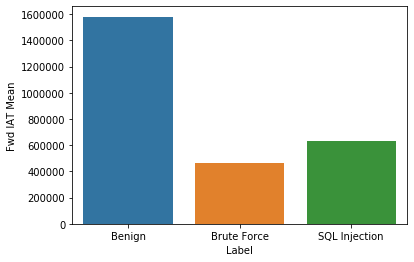

In [0]:
ax = sns.barplot(x='Label', y='Fwd IAT Mean', data=avg_time)


In [0]:
avg_time

,Label,Fwd IAT Mean
0,Benign,1.580595e+06
1,Brute Force,4.648417e+05
2,SQL Injection,6.346890e+05


## Splitting Data into Train and Test Sets

In [0]:
y = df['Target'] 
y1 = y.copy()
df.drop(columns=['Label', 'Target'], inplace=True)
print(df.columns)

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max'

In [0]:
df.shape

(842370, 56)

In [0]:
Y = label_binarize(y1, classes=[0,1,2])
n_classes = Y.shape[1]

X, X_test, y, y_test = train_test_split(df, Y, test_size=0.20, random_state=72, stratify = Y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=72, stratify = y)


**ADASYN Oversampling**  
This data is highly imbalanced as seen by the class distribution earlier. One of the methods I am going to use to address this issue is ADASYN oversampling to synthetically generate new data points for my attack classes.

In [0]:
#X_adasyn, y_adasyn = ADASYN(random_state=71).fit_sample(X_train, y_train)
#X_adasyn_df = pd.DataFrame(X_adasyn, columns=X_train.columns) 

In [0]:
#X_adasyn_df.head()

In [0]:
y_train.shape

(505422, 3)

## Logistic Regression

In [0]:
class_labels = ['Benign', 'Brute Force', 'SQL Injection']

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

logit = OneVsRestClassifier(LogisticRegression(C = 10, solver='lbfgs', max_iter=1000), n_jobs=-1)
logit.fit(X_train_scaled, y_train)
y_pred = logit.predict(X_val_scaled)
y_score_logit = logit.predict_proba(X_val_scaled)

print(classification_report(y_val, y_pred, target_names=class_labels))

               precision    recall  f1-score   support

       Benign       1.00      1.00      1.00    168386
  Brute Force       0.91      0.97      0.94        76
SQL Injection       0.89      0.67      0.76        12

    micro avg       1.00      1.00      1.00    168474
    macro avg       0.93      0.88      0.90    168474
 weighted avg       1.00      1.00      1.00    168474
  samples avg       1.00      1.00      1.00    168474



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.



**Saga Logistic Regression**

In [0]:
logit.feature_names = X_train.columns.tolist()
logit.target_names = class_labels

def plot_ovr_coefs(model):
    """Helper to plot coefficients of a ovr model like Logistic Regression"""
    n_models, n_coef = model.coef_.shape
    visual_cols = ['Fwd Pkt Len Max', 'Fwd IAT Max', 'Bwd IAT Min', 'ECE Flag Cnt', 'RST Flag Cnt']

    lod = []
    for i in range(n_models):
        for j in range(n_coef):
          if model.feature_names[j] in visual_cols:
              lod.append({
                  "OVR Model": f"{model.target_names[i]} vs rest",
                  "Coefficient Name": f"{model.feature_names[j]}",
                  "Coefficient Value": model.coef_[i,j]
              })
    coef_df = pd.DataFrame(lod)

    fig, ax = plt.subplots(figsize=(8,8))
    sns.barplot(y="Coefficient Name", x="Coefficient Value", hue="OVR Model", orient="h", data=coef_df)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plot_ovr_coefs(logit)

In [0]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=50,
                             max_depth=3,
                             random_state=0))
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_val)

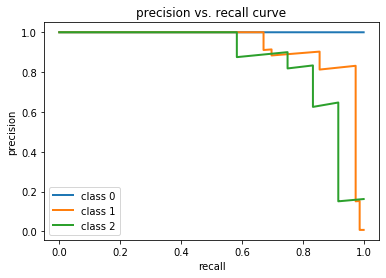

In [0]:
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [0]:
y_val.shape

(168474, 3)

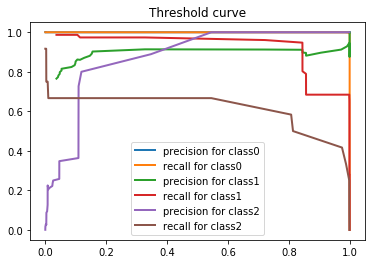

In [0]:
precision = dict()
recall = dict()
threshold = dict()

for i in range(3):
    precision[i], recall[i], threshold[i] = precision_recall_curve(y_val[:, i],
                                                        y_score_logit[:, i])
    plt.plot(threshold[i], precision[i][1:], lw=2, label='precision for class' + str(i))
    plt.plot(threshold[i], recall[i][1:], lw=2, label='recall for class' + str(i))

plt.legend(loc="best")
plt.title("Threshold curve")
plt.show()
#macro avg       precision:0.93      recall:0.88  

In [0]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 
def plot_threshold_curve(X_val, y_val, model):
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, model.predict_proba(X_val)[:,1]);

    plt.figure(dpi=80);
    plt.plot(threshold_curve, precision_curve[1:],label='precision');
    plt.plot(threshold_curve, recall_curve[1:], label='recall');
    plt.legend(loc='lower left');
    plt.xlabel('Threshold (above this probability, label as positive)');
    
    return plt;

In [0]:
#C = np.logspace(-4, 4, 20)
#hyperparameters = dict(C=C)
#logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
#grid_logistic = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
#grid_logistic.fit(X_train_scaled, y_train)
#print('Best C:', grid_logit.best_estimator_.get_params()['C'])
#y_pred = grid_logistic.predict(X_val_scaled)

**Brute Most Important**  
1) Fwd IAT Std  
2) Fwd Act Data Pkts  
3) Tot Fwd Pkts  
4) ECE Flag Cnt	
5) RST Flag Cnt  
  
**SQL Most Important**  
1) ECE Flag Cnt  
2) RST Flag Cnt  
3) Bwd Pkt Len Mean  
4) Fwd IAT Mean  
5) TotLen Fwd Pkts	


## Baseline Modeling

In [0]:
numeric_features = X_train.columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [0]:
y_train.value_counts()

**With ADASYN**

In [0]:
class_labels = ['Benign', 'Brute Force', 'SQL Injection']

clf = RandomForestClassifier(n_estimators=50)

clf.fit(X_adasyn,y_adasyn)
y_pred_val = clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=class_labels))

**Without ADASYN**

In [0]:
class_labels = ['Benign', 'Brute Force', 'SQL Injection']

clf = RandomForestClassifier(n_estimators=50)

clf.fit(X_train,y_train)
y_pred_val = clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=class_labels))

In [0]:
c

In [0]:
class_labels = ['Benign', 'Brute Force', 'SQL Injection']

clf = RandomForestClassifier(n_estimators=50)

clf.fit(X_train,y_train)
y_pred_val = clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=class_labels))

In [0]:
feature_importances = pd.DataFrame(index=X_train.columns.tolist())
feature_importances['Weight'] = clf.feature_importances_ 
feature_importances.sort_values(by=['Weight'], ascending=False)

In [0]:
class_labels = ['Benign', 'Brute Force', 'SQL Injection']

classifiers = [
    RandomForestClassifier(),
    KNeighborsClassifier(10),
    SVC(kernel="linear", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    y_pipe_val = pipe.predict(X_val)
    print(classifier)
    print(classification_report(y_val, y_pipe_val, target_names=class_labels))
    print('')

In [0]:
"bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,

## Light GBM Classification

In [0]:
lgb_model = lgb.LGBMClassifier(#boosting_type='rf',
                                   max_depth=-1,
                                   n_estimators=1000,
                                   learning_rate=0.1,
                                   num_leaves=200,
                                   min_child_samples=7500,
                                   colsample_bytree = 0.3,
                                   objective='multiclass', 
                                   n_jobs=-1,
                                   bagging_freq = 1,
                                   bagging_fraction = 0.8,
                                   bagging_seed = 71,
                                   random_state=33)

NameError: ignored

In [0]:
lgb_model.fit(X_train, y_train,  
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=300)

y_pred = lgb_model.predict(X_test.values) 

In [0]:
print('F1:', f1_score(y_test,y_pred,average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('Precision:', precision_score(y_test, y_pred, average='macro')) 

In [0]:
y_train.value_counts()

In [0]:
def print_confusion_matrix(conf_mat):
  classes = ['Benign', 'BruteForce', 'SQL Injection']
  new_classes = ['SQL Injection', 'BruteForce', 'Benign']
  df_cm = pd.DataFrame(conf_mat, index=new_classes,  columns=classes)
  temp = df_cm.iloc[0].copy()
  df_cm.iloc[0] = df_cm.iloc[2]
  df_cm.iloc[2] = temp  
  fig = plt.figure(figsize=(10,5))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
  plt.ylabel('True label', size=18)
  plt.xlabel('Predicted label', size=18);

In [0]:
conf_mat = confusion_matrix(y_test,y_pred) 
print_confusion_matrix(conf_mat) 

In [0]:
feature_importances = pd.DataFrame(index=X_train.columns.tolist())
feature_importances['Weight'] = lgb_model.feature_importances_
feature_importances.sort_values(by=['Weight'], ascending=False)

In [0]:
y_train.value_counts()